## Data Collection: Automatic Webcam Image Capture

This cell captures images automatically from a webcam at fixed time intervals and saves them to disk.
The collected images are intended for later manual labeling and pose analysis.

In [36]:
import cv2
import os
import uuid
import time

# ----------------------------
# Paths & settings
# ----------------------------
IMAGES_PATH = "data/images_raw"
os.makedirs(IMAGES_PATH, exist_ok=True)
number_images = 200       # total images to capture
delay_between = 0.5      # seconds between captures

# ----------------------------
# Open camera
# ----------------------------
cap = cv2.VideoCapture(1)

# Warm up camera
for _ in range(10):
    ret, frame = cap.read()

print("Capturing images automatically...")

# ----------------------------
# Automatic capture loop
# ----------------------------
imgnum = 0
while imgnum < number_images:
    ret, frame = cap.read()
    if not ret or frame is None:
        continue

    # Display the frame (optional)
    cv2.imshow("Frame", frame)

    # Save image
    imgname = os.path.join(IMAGES_PATH, f"{uuid.uuid1()}.jpg")
    cv2.imwrite(imgname, frame)
    print(f"Saved {imgname}")
    imgnum += 1

    # Wait before next capture
    time.sleep(delay_between)

    # Allow quit with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ----------------------------
# Proper cleanup
# ----------------------------
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)  # flush window events
time.sleep(0.1) # ensure window closes
print("Done capturing images! All OpenCV windows closed.")


2026-01-30 10:02:47.055 Python[73678:29691829] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Capturing images automatically...
Saved data/images_raw/bb350b2a-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bb94f3b4-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bbe6c108-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bc3d1c1a-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bc982ab0-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bce9bcae-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bd407fa8-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bd96bc42-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bded205a-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/be4377ca-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/be9a2b2e-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bef04a72-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bf472a90-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bf9d5870-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw/bff386b4-fd94-11f0-9cb6-c288c7b5f717.jpg
Saved data/images_raw

In [134]:
import cv2
import os

# ----------------------------
# 1. Setup & Paths
# ----------------------------
VIDEO_PATH = "alcaraz.mp4"
OUTPUT_FOLDER = "data/images_raw"

# Create the folder if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ----------------------------
# 2. Extraction Logic
# ----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print(f"Error: Could not open video {VIDEO_PATH}")
else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval_frames = int(fps / 2)  # Extract every 0.5 seconds
    
    frame_count = 0
    saved_count = 0
    
    # Get the base name of the video to avoid overwriting files from other videos
    video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]

    print(f"Extracting frames from {video_name}...")

    while True:
        # Set the position to the specific frame we want
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        ret, frame = cap.read()
        
        if not ret:
            break

        # Generate a unique filename: video_name + frame_index
        file_name = f"{video_name}_frame_{frame_count}.jpg"
        file_path = os.path.join(OUTPUT_FOLDER, file_name)
        
        # Save the image
        cv2.imwrite(file_path, frame)
        
        saved_count += 1
        frame_count += interval_frames

    cap.release()
    print(f"✅ Success! Saved {saved_count} frames to {OUTPUT_FOLDER}")

Extracting frames from alcaraz...
✅ Success! Saved 386 frames to data/images_raw


## Data Inspection: Random Image Sampling

This cell displays a random subset of images from the collected dataset.
It is used to quickly verify image quality, framing, and capture consistency.

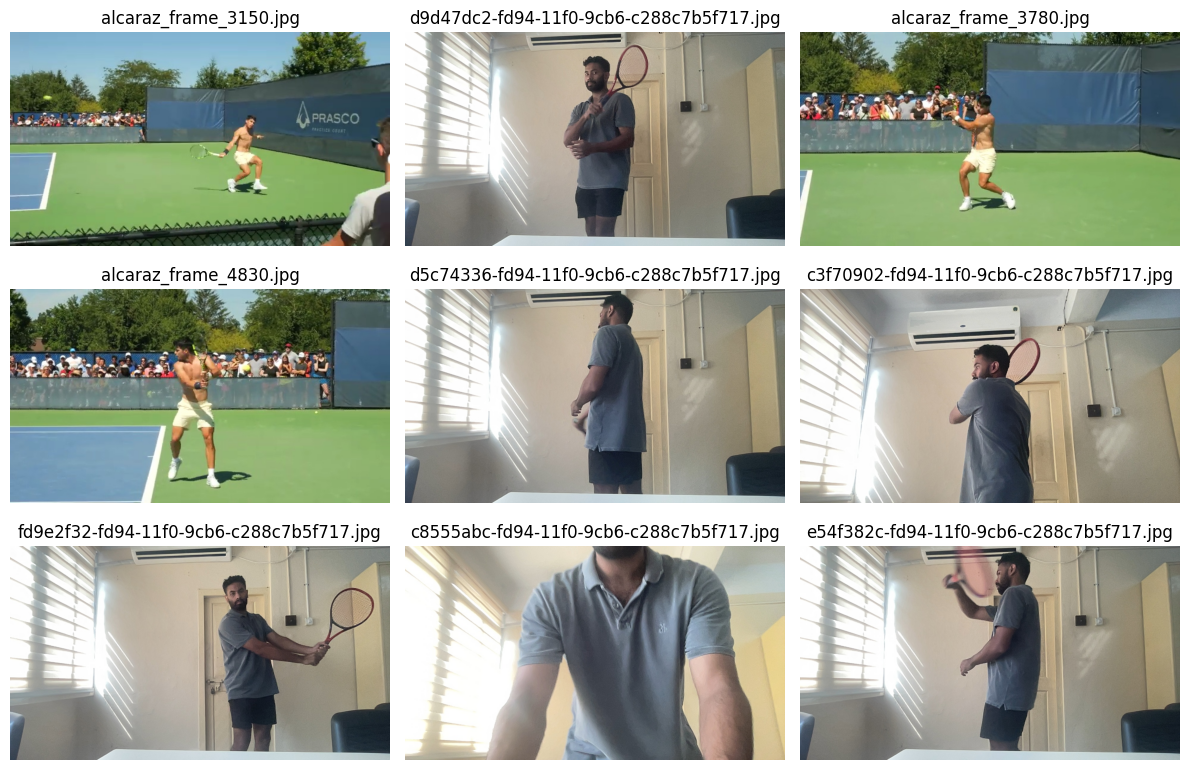

In [137]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ----------------------------
# Paths & settings
# ----------------------------
IMAGES_PATH = "data/images_raw"
num_samples = 9  # how many random images to show

# Get all image files
image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.png'))]

# Pick random samples
sample_files = random.sample(image_files, min(num_samples, len(image_files)))

# ----------------------------
# Plot images in a grid
# ----------------------------
cols = 3
rows = (len(sample_files) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

for ax, img_file in zip(axes, sample_files):
    img_path = os.path.join(IMAGES_PATH, img_file)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')

# Hide any extra axes
for ax in axes[len(sample_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Manual Image Labeling Interface

This cell provides a simple interactive tool to assign categorical labels
to each image in the dataset and save the annotations as JSON files.

In [138]:
import os
import json
from IPython.display import display
from PIL import Image
import ipywidgets as widgets

# ----------------------------
# Paths
# ----------------------------
IMAGES_PATH = "data/images_raw"
ANNOTATIONS_PATH = "data/labels"
os.makedirs(ANNOTATIONS_PATH, exist_ok=True)

# 1. Filter: Only get images that DO NOT have a matching JSON file yet
all_images = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.png'))]
images = [f for f in all_images if not os.path.exists(os.path.join(ANNOTATIONS_PATH, f + ".json"))]
images.sort()

current_idx = 0

# ----------------------------
# Widgets
# ----------------------------
image_widget = widgets.Image()
label_dropdown = widgets.Dropdown(
    options=["backhand", "neutral"],
    description="Label:"
)
next_button = widgets.Button(description="Save & Next", button_style='success')
skip_button = widgets.Button(description="Skip Frame", button_style='warning')
progress_label = widgets.Label()

output = widgets.Output()

def update_display(idx):
    if idx < len(images):
        filename = images[idx]
        path = os.path.join(IMAGES_PATH, filename)
        with open(path, "rb") as f:
            image_widget.value = f.read()
        progress_label.value = f"Image {idx + 1} of {len(images)} (Unlabeled only)"
    else:
        progress_label.value = "🎉 All images labeled!"
        next_button.disabled = True
        skip_button.disabled = True

def save_label(idx):
    filename = images[idx]
    label = label_dropdown.value
    ann_file = os.path.join(ANNOTATIONS_PATH, filename + ".json")
    with open(ann_file, "w") as f:
        json.dump({"image": filename, "label": label}, f)
    with output:
        print(f"✅ Labeled {filename} as {label}")

def on_next(b):
    global current_idx
    output.clear_output()
    save_label(current_idx)
    current_idx += 1
    update_display(current_idx)

def on_skip(b):
    global current_idx
    output.clear_output()
    with output:
        print(f"⏭️ Skipped {images[current_idx]}")
    current_idx += 1
    update_display(current_idx)

next_button.on_click(on_next)
skip_button.on_click(on_skip)

# ----------------------------
# Display Initial State
# ----------------------------
if images:
    update_display(current_idx)
    display(widgets.VBox([progress_label, image_widget, label_dropdown, 
                          widgets.HBox([next_button, skip_button]), output]))
else:
    print("No new images to label! Everything in this folder is already annotated.")

## Visual Verification of Image Labels

This cell displays a random subset of labeled images together with their
assigned class labels to quickly verify annotation quality and consistency.


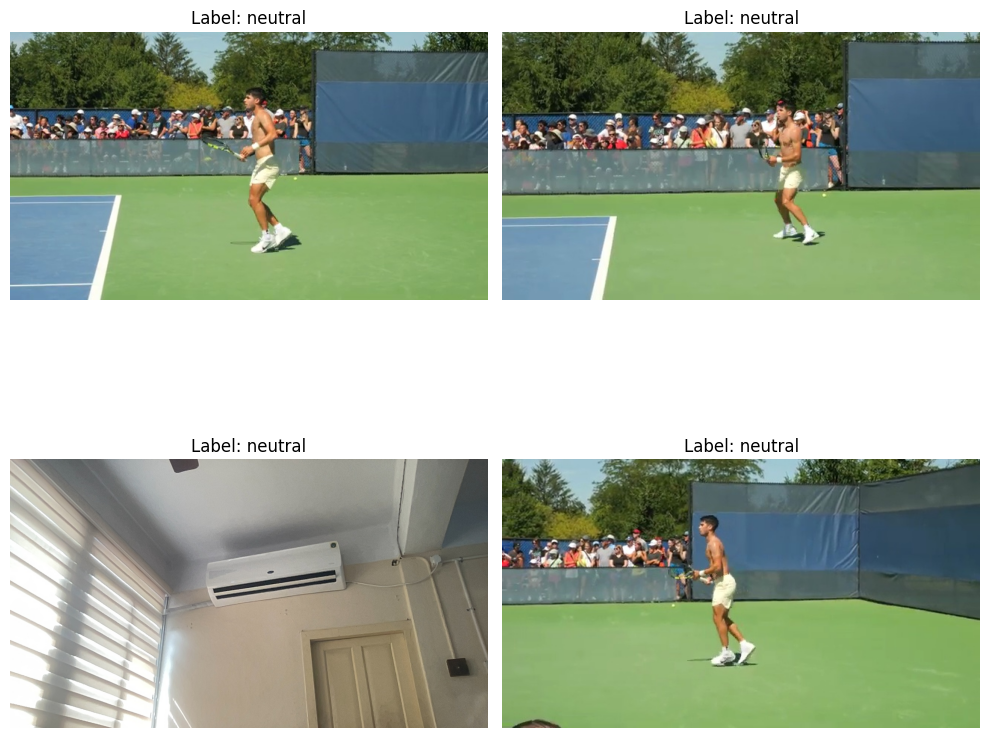

In [139]:
import os
import json
import random
from PIL import Image
import matplotlib.pyplot as plt

IMAGES_PATH = "data/images_raw"
ANNOTATIONS_PATH = "data/labels"

# Load labels
labels = {}
for f in os.listdir(ANNOTATIONS_PATH):
    if f.endswith(".json"):
        with open(os.path.join(ANNOTATIONS_PATH, f)) as jf:
            data = json.load(jf)
            labels[data["image"]] = data["label"]

# Get random sample
images = list(labels.keys())
sample_images = random.sample(images, min(4, len(images)))  # 4 random images

# Display
fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

for ax, img_file in zip(axes, sample_images):
    img_path = os.path.join(IMAGES_PATH, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label: {labels[img_file]}")

plt.tight_layout()
plt.show()


## Pose Extraction and Skeleton Normalization

This cell uses MediaPipe’s Pose Landmarker to extract key body joints from each
image, normalize joint coordinates relative to body geometry, and pair the
resulting skeleton data with the corresponding action labels.

In [228]:
import os
import json
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tqdm.notebook import tqdm

# 1. Paths
IMAGES_PATH = "data/images_raw"
ANNOTATIONS_PATH = "data/labels"
OUTPUT_PATH = "data/skeletons"
MODEL_PATH = 'pose_landmarker_full.task' 
os.makedirs(OUTPUT_PATH, exist_ok=True)

# 2. Updated joints: Added 0, 2, 5 (Face) + your original 8 joints
RELEVANT_JOINTS = [0, 2, 5, 11, 12, 13, 14, 15, 16, 23, 24]

# 3. Setup the Detector
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5
)

# 4. Processing Loop
images = sorted([f for f in os.listdir(IMAGES_PATH) if f.lower().endswith((".jpg", ".png"))])
skeletons = []

with vision.PoseLandmarker.create_from_options(options) as landmarker:
    for img_file in tqdm(images, desc="Processing Tennis Images"):
        img_path = os.path.join(IMAGES_PATH, img_file)
        mp_image = mp.Image.create_from_file(img_path)
        result = landmarker.detect(mp_image)

        # Default values if no pose detected
        joints_norm = [[0, 0, 0] for _ in RELEVANT_JOINTS]
        joints_abs = None

        if result.pose_landmarks:
            landmarks = result.pose_landmarks[0]
            h, w = mp_image.height, mp_image.width
            
            # 5. Extract Absolute Coordinates (Exactly as before: full 33 landmarks)
            joints_abs_list = np.array([(lm.x * w, lm.y * h) for lm in landmarks])
            
            # 6. Normalize relative to mid-hip and scale by shoulder width
            left_hip, right_hip = joints_abs_list[23], joints_abs_list[24]
            mid_hip = (left_hip + right_hip) / 2
            
            left_shoulder, right_shoulder = joints_abs_list[11], joints_abs_list[12]
            shoulder_dist = np.linalg.norm(left_shoulder - right_shoulder)
            
            # 7. Filter for RELEVANT_JOINTS and add visibility
            joints_norm = []
            for j in RELEVANT_JOINTS:
                lm = landmarks[j]
                # Calculate normalized X and Y (Exactly as before)
                norm_x = (joints_abs_list[j][0] - mid_hip[0]) / (shoulder_dist if shoulder_dist > 0.001 else 1.0)
                norm_y = (joints_abs_list[j][1] - mid_hip[1]) / (shoulder_dist if shoulder_dist > 0.001 else 1.0)
                
                # Append [x, y, visibility]
                joints_norm.append([float(norm_x), float(norm_y), float(lm.visibility)])

            joints_abs = joints_abs_list.tolist()

        # 8. Pair with your JSON label
        label_file = os.path.join(ANNOTATIONS_PATH, img_file + ".json")
        try:
            with open(label_file) as f:
                label = json.load(f)["label"]
        except FileNotFoundError:
            label = "unlabeled"

        skeletons.append({
            "image": img_file,
            "joints_abs": joints_abs,
            "joints_norm": joints_norm,
            "label": label
        })

# 9. Save final dataset
output_file = os.path.join(OUTPUT_PATH, "skeletons.json")
with open(output_file, "w") as f:
    json.dump(skeletons, f, indent=2)

print(f"✅ Saved {len(skeletons)} skeletons to {output_file}")

I0000 00:00:1769754518.128484 30323306 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1769754518.205273 30323313 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769754518.234902 30323316 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing Tennis Images:   0%|          | 0/586 [00:00<?, ?it/s]

✅ Saved 586 skeletons to data/skeletons/skeletons.json


## Pose Estimation Verification

This cell visualizes a random subset of images with the estimated pose skeletons overlaid.  
It serves as a sanity check to confirm that joint detection and normalization are working correctly before using the data for modeling.


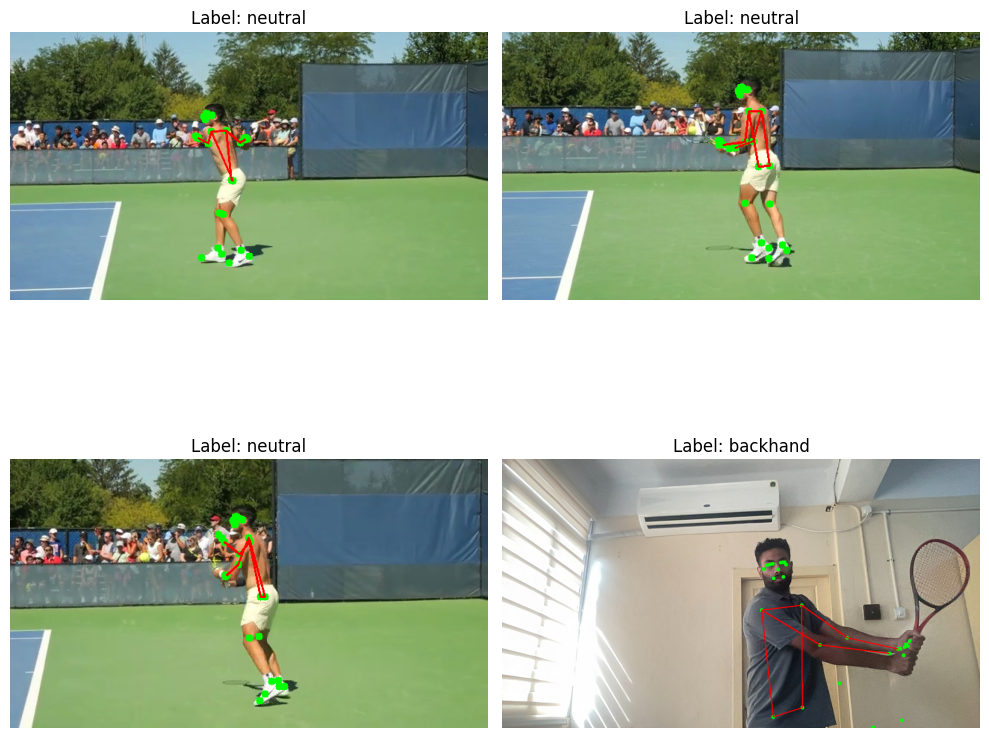

In [230]:
import json
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Paths & settings
# ----------------------------
IMAGES_PATH = "data/images_raw"
SKELETONS_PATH = "data/skeletons/skeletons.json"
NUM_SAMPLES = 4  # number of random images to visualize

# ----------------------------
# Load skeleton data
# ----------------------------
with open(SKELETONS_PATH, "r") as f:
    skeletons = json.load(f)

# Filter only entries with detected poses
valid_skeletons = [s for s in skeletons if s["joints_abs"] is not None]

# Random sample
samples = random.sample(valid_skeletons, min(NUM_SAMPLES, len(valid_skeletons)))

# ----------------------------
# MediaPipe pose connections (for drawing bones)
# ----------------------------
POSE_CONNECTIONS = [
    (11, 13), (13, 15),   # left arm
    (12, 14), (14, 16),   # right arm
    (11, 12),             # shoulders
    (11, 23), (12, 24),   # torso
    (23, 24)              # hips
]

# ----------------------------
# Plot
# ----------------------------
cols = 2
rows = (len(samples) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

for ax, sample in zip(axes, samples):
    img_path = os.path.join(IMAGES_PATH, sample["image"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    joints = np.array(sample["joints_abs"])

    # Draw joints
    for (x, y) in joints:
        cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Draw bones
    for i, j in POSE_CONNECTIONS:
        if i < len(joints) and j < len(joints):
            pt1 = joints[i]
            pt2 = joints[j]
            cv2.line(
                img,
                (int(pt1[0]), int(pt1[1])),
                (int(pt2[0]), int(pt2[1])),
                (255, 0, 0),
                2
            )

    ax.imshow(img)
    ax.set_title(f"Label: {sample['label']}")
    ax.axis("off")

# Hide unused axes
for ax in axes[len(samples):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


## Model Definition & Training
This cell defines a **Multilayer Perceptron (MLP)** architecture tailored for classified body pose coordinates. 
It processes the normalized joint data, trains the network using backpropagation, and evaluates the final accuracy to ensure the model can effectively distinguish between different tennis strokes.

In [233]:
import json
import numpy as np
import os
import joblib
import random
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# ----------------------------
# 1. Load and Randomize Data
# ----------------------------
DATA_PATH = "data/skeletons/skeletons.json"
with open(DATA_PATH) as f:
    data = json.load(f)

# Pair X and y for a clean shuffle
combined_data = []
for sample in data:
    if sample["label"] == "unlabeled": 
        continue
    
    # Flatten the (11, 3) matrix into a (33,) vector
    features = np.array(sample["joints_norm"]).flatten()
    combined_data.append((features, sample["label"]))

# RANDOMIZE: This ensures backhands and neutrals are mixed together
random.seed(42)
random.shuffle(combined_data)

X = np.array([item[0] for item in combined_data], dtype=np.float32)
y = np.array([item[1] for item in combined_data])

# ----------------------------
# 2. Preprocessing
# ----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
backhand_idx = list(le.classes_).index('backhand')
neutral_idx = list(le.classes_).index('neutral')

# Stratify ensures the 1:2.2 ratio is identical in Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ----------------------------
# 3. Class Weights (The "Hammer")
# ----------------------------
# We stick with 3.0 because it successfully stopped the "Everything is Neutral" bug
class_weight_dict = {
    neutral_idx: 1.0,
    backhand_idx: 3.0  
}

print(f"Backhand Index: {backhand_idx} | Weights: {class_weight_dict}")

# ----------------------------
# 4. Build Model (Updated for 33 inputs)
# ----------------------------
model = models.Sequential([
    # Input shape is now 33 (11 joints * [x, y, vis])
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(33,)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# 5. Train
# ----------------------------
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=50, # Increased patience to allow more time to learn with face data
    restore_best_weights=True
)

print("\nStarting Training...")
model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# ----------------------------
# 6. Save & Evaluate
# ----------------------------
MODEL_DIR = "models/tennis_stroke"
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, "tennis_model_keras.h5"))
joblib.dump(le, os.path.join(MODEL_DIR, "label_encoder_keras.pkl"))

y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nFinal Classification Report (33 Inputs):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Backhand Index: 0 | Weights: {1: 1.0, 0: 3.0}

Starting Training...
Epoch 1/300


/Users/paulimmanuel/Desktop/tennis_stroke_3/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6418 - loss: 1.4908 - val_accuracy: 0.8310 - val_loss: 0.4370
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7305 - loss: 0.8186 - val_accuracy: 0.7606 - val_loss: 0.4957
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7589 - loss: 0.6523 - val_accuracy: 0.8451 - val_loss: 0.3750
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8511 - loss: 0.6731 - val_accuracy: 0.8592 - val_loss: 0.3482
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 0.6766 - val_accuracy: 0.8310 - val_loss: 0.3749
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8298 - loss: 0.6622 - val_accuracy: 0.8732 - val_loss: 0.3520
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.6152 - val_accuracy: 0.9014 - val_loss: 0.3260
Epoch 8/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss: 0.5557 - val_accuracy: 0.8873 - val_loss: 0.3

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Final Classification Report (33 Inputs):
              precision    recall  f1-score   support

    backhand       1.00      0.91      0.95        22
     neutral       0.96      1.00      0.98        49

    accuracy                           0.97        71
   macro avg       0.98      0.95      0.97        71
weighted avg       0.97      0.97      0.97        71



# Main Model Inference and Visual Validation
### Skeleton-Based Action Classification with Coordinate Normalization
---

I0000 00:00:1769754806.421274 30334487 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1769754806.476333 30334489 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769754806.495322 30334490 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


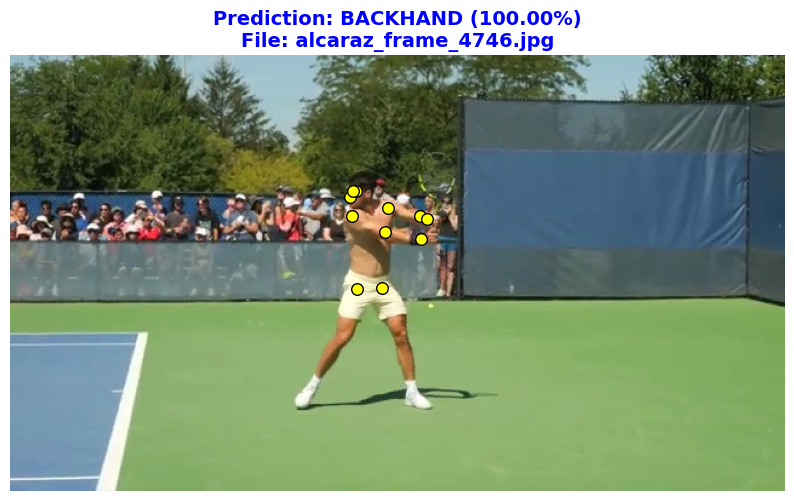

In [249]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import joblib
import matplotlib.pyplot as plt
import urllib.request
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# ----------------------------
# 1. Setup & Auto-Download Model
# ----------------------------
MODEL_ASSET_PATH = 'pose_landmarker_heavy.task'
MODEL_URL = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task"

if not os.path.exists(MODEL_ASSET_PATH):
    print(f"Downloading {MODEL_ASSET_PATH}...")
    urllib.request.urlretrieve(MODEL_URL, MODEL_ASSET_PATH)

KERAS_MODEL_PATH = "models/tennis_stroke/tennis_model_keras.h5"
ENCODER_PATH = "models/tennis_stroke/label_encoder_keras.pkl"

keras_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
le = joblib.load(ENCODER_PATH)

# ----------------------------
# 2. Configure MediaPipe Task
# ----------------------------
options = vision.PoseLandmarkerOptions(
    base_options=python.BaseOptions(model_asset_path=MODEL_ASSET_PATH),
    running_mode=vision.RunningMode.IMAGE)

# ----------------------------
# 3. Pick a Random Image
# ----------------------------
IMAGES_PATH = "data/images_raw"
all_images = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
random_img_name = random.choice(all_images)
img_path = os.path.join(IMAGES_PATH, random_img_name)

# ----------------------------
# 4. Run Inference with Normalization
# ----------------------------
with vision.PoseLandmarker.create_from_options(options) as landmarker:
    mp_image = mp.Image.create_from_file(img_path)
    detection_result = landmarker.detect(mp_image)

    if detection_result.pose_landmarks:
        pose_landmarks = detection_result.pose_landmarks[0]
        h, w = mp_image.height, mp_image.width
        
        # We need ALL landmarks to calculate the mid-hip and shoulder distance
        all_coords = np.array([(lm.x * w, lm.y * h) for lm in pose_landmarks])
        
        # 1. Calculate Normalization Factors (Exactly like training)
        left_hip, right_hip = all_coords[23], all_coords[24]
        mid_hip = (left_hip + right_hip) / 2
        
        left_shoulder, right_shoulder = all_coords[11], all_coords[12]
        shoulder_dist = np.linalg.norm(left_shoulder - right_shoulder)
        if shoulder_dist < 0.001: shoulder_dist = 1.0 # Prevent division by zero

        # 2. Extract 11 Joints (33 values: x, y, visibility)
        relevant_indices = [0, 2, 5, 11, 12, 13, 14, 15, 16, 23, 24]
        input_vector = []
        
        for idx in relevant_indices:
            lm = pose_landmarks[idx]
            # Normalize X and Y relative to hip and shoulder scale
            norm_x = (all_coords[idx][0] - mid_hip[0]) / shoulder_dist
            norm_y = (all_coords[idx][1] - mid_hip[1]) / shoulder_dist
            
            input_vector.extend([float(norm_x), float(norm_y), float(lm.visibility)])
            
        # 3. Keras Prediction
        input_data = np.array([input_vector], dtype=np.float32)
        predictions = keras_model.predict(input_data, verbose=0)
        class_idx = np.argmax(predictions)
        confidence = np.max(predictions)
        label = le.inverse_transform([class_idx])[0]

        # ----------------------------
        # 5. Visualization
        # ----------------------------
        output_image = mp_image.numpy_view()
        plt.figure(figsize=(10, 8))
        plt.imshow(output_image)
        
        # Plot the 11 joints used for prediction
        for idx in relevant_indices:
            px_x, px_y = int(all_coords[idx][0]), int(all_coords[idx][1])
            plt.scatter(px_x, px_y, c='yellow', edgecolors='black', s=70, zorder=3)

        title_color = 'blue' if label.lower() == 'backhand' else 'green'
        plt.title(f"Prediction: {label.upper()} ({confidence:.2%})\nFile: {random_img_name}", 
                  fontsize=14, fontweight='bold', color=title_color)
        plt.axis('off')
        plt.show()
    else:
        print(f"No pose detected in {random_img_name}")

# Primary Action Recognition and Automated Video Segmentation
### Skeleton-Based Motion Analysis for Real-Time Event Detection and Storage
---

In [272]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import joblib
import os
from collections import deque
from mediapipe.tasks import python

# ----------------------------
# 1. Config & Paths
# ----------------------------
VIDEO_PATH = "r.mp4"
OUTPUT_FOLDER = "backhand_clips"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

MODEL_ASSET_PATH = 'pose_landmarker_heavy.task'
KERAS_MODEL_PATH = "models/tennis_stroke/tennis_model_keras.h5"
ENCODER_PATH = "models/tennis_stroke/label_encoder_keras.pkl"

keras_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
le = joblib.load(ENCODER_PATH)

# ----------------------------
# 2. MediaPipe & Video Setup
# ----------------------------
base_options = python.BaseOptions(model_asset_path=MODEL_ASSET_PATH)
options = mp.tasks.vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=mp.tasks.vision.RunningMode.VIDEO)

cap = cv2.VideoCapture(VIDEO_PATH)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Buffer for "before" clip (1 second)
buffer_size = fps 
frame_buffer = deque(maxlen=buffer_size)

# ----------------------------
# 3. Processing Loop
# ----------------------------
print(f"Analyzing video... (Scanning for backhands)")

with mp.tasks.vision.PoseLandmarker.create_from_options(options) as landmarker:
    frame_count = 0
    clip_count = 0
    frames_to_record = 0
    current_writer = None
    cooldown_frames = 0 

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        timestamp_ms = int(1000 * frame_count / fps)
        frame_count += 1
        
        # We always add to the buffer so the "past" is always fresh
        frame_buffer.append(frame.copy())
        
        if cooldown_frames > 0: cooldown_frames -= 1
        
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        result = landmarker.detect_for_video(mp_image, timestamp_ms)

        is_backhand = False
        if result.pose_landmarks:
            landmarks = result.pose_landmarks[0]
            all_coords = np.array([(lm.x * width, lm.y * height) for lm in landmarks])
            mid_hip = (all_coords[23] + all_coords[24]) / 2
            shoulder_dist = np.linalg.norm(all_coords[11] - all_coords[12])
            if shoulder_dist < 0.001: shoulder_dist = 1.0

            relevant_indices = [0, 2, 5, 11, 12, 13, 14, 15, 16, 23, 24]
            input_vector = []
            for idx in relevant_indices:
                lm = landmarks[idx]
                norm_x = (all_coords[idx][0] - mid_hip[0]) / shoulder_dist
                norm_y = (all_coords[idx][1] - mid_hip[1]) / shoulder_dist
                input_vector.extend([float(norm_x), float(norm_y), float(lm.visibility)])
            
            input_data = np.array([input_vector], dtype=np.float32)
            preds = keras_model.predict_on_batch(input_data)
            class_idx = np.argmax(preds[0])
            confidence = preds[0][class_idx]
            label = le.inverse_transform([class_idx])[0]
            
            if label.lower() == "backhand" and confidence > 0.85 and cooldown_frames == 0:
                is_backhand = True

        # ----------------------------
        # 4. Logic: Improved Saving Logic
        # ----------------------------
        
        # Start a new recording
        if is_backhand and frames_to_record <= 0:
            clip_count += 1
            clip_name = os.path.join(OUTPUT_FOLDER, f"backhand_{clip_count}.mp4")
            current_writer = cv2.VideoWriter(clip_name, fourcc, fps, (width, height))
            
            # Write everything in the buffer (the 1s before)
            for buf_frame in frame_buffer:
                current_writer.write(buf_frame)
            
            frames_to_record = int(fps * 1.5) 
            cooldown_frames = fps * 2
            print(f"  >> Captured backhand #{clip_count} at {frame_count/fps:.1f}s")

        # Continue recording current clip
        elif frames_to_record > 0:
            current_writer.write(frame)
            frames_to_record -= 1
            
            # Close the writer when done
            if frames_to_record == 0:
                current_writer.release()
                current_writer = None

cap.release()
if current_writer: current_writer.release()
print(f"\n✅ Done! Found {clip_count} backhand(s).")

I0000 00:00:1769765297.162864 30464413 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1769765297.213662 30464414 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769765297.289644 30464414 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Analyzing video... (Scanning for backhands)
  >> Captured backhand #1 at 2.1s
  >> Captured backhand #2 at 4.1s
  >> Captured backhand #3 at 6.3s
  >> Captured backhand #4 at 11.3s
  >> Captured backhand #5 at 15.3s
  >> Captured backhand #6 at 18.2s
  >> Captured backhand #7 at 20.7s
  >> Captured backhand #8 at 25.7s
  >> Captured backhand #9 at 28.2s
  >> Captured backhand #10 at 31.1s
  >> Captured backhand #11 at 38.9s
  >> Captured backhand #12 at 46.4s
  >> Captured backhand #13 at 49.0s
  >> Captured backhand #14 at 52.1s
  >> Captured backhand #15 at 55.8s

✅ Done! Found 15 backhand(s).


# Tennis Dataset Integrity and Distribution Analysis
### Automated Audit of Class Balance for Neural Network Optimization
---

In [232]:
import json
import os
from collections import Counter

# 1. Path to your combined dataset
SKELETON_FILE = "data/skeletons/skeletons.json"

if not os.path.exists(SKELETON_FILE):
    print(f"Error: Could not find {SKELETON_FILE}")
else:
    with open(SKELETON_FILE, 'r') as f:
        data = json.load(f)

    # 2. Extract all labels
    labels = [item.get('label', 'unlabeled') for item in data]
    total = len(labels)
    counts = Counter(labels)

    # 3. Print a clean summary
    print("-" * 30)
    print(f"DATASET SUMMARY: {total} total samples")
    print("-" * 30)
    
    for label, count in counts.items():
        percentage = (count / total) * 100
        print(f"{label.upper():<12}: {count:>4}  ({percentage:>5.1f}%)")
    
    print("-" * 30)

    # 4. Strategic Advice
    backhand_count = counts.get('backhand', 0)
    neutral_count = counts.get('neutral', 0)
    
    if total > 0:
        ratio = neutral_count / (backhand_count if backhand_count > 0 else 1)
        
        if ratio > 4:
            print(f"⚠️  WARNING: Skew is too high! (Ratio 1:{ratio:.1f})")
            print("Your model will likely struggle to find backhands.")
            print(f"Advice: Label at least {int(neutral_count/2) - backhand_count} more backhands.")
        elif 'unlabeled' in counts:
            print(f"💡 TIP: You have {counts['unlabeled']} unlabeled skeletons.")
            print("Labeling these might help balance the scales.")
        else:
            print("✅ Dataset balance looks manageable for training with class weights.")

------------------------------
DATASET SUMMARY: 353 total samples
------------------------------
BACKHAND    :  109  ( 30.9%)
NEUTRAL     :  244  ( 69.1%)
------------------------------
✅ Dataset balance looks manageable for training with class weights.


In [231]:
import json
import os
import random

# 1. Path to your dataset
SKELETON_FILE = "data/skeletons/skeletons.json"
BACKUP_FILE = "data/skeletons/skeletons_backup.json"

if not os.path.exists(SKELETON_FILE):
    print(f"Error: Could not find {SKELETON_FILE}")
else:
    with open(SKELETON_FILE, 'r') as f:
        data = json.load(f)

    # Create a backup just in case
    with open(BACKUP_FILE, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Backup created at {BACKUP_FILE}")

    # 2. Separate the classes
    backhands = [item for item in data if item.get('label') == 'backhand']
    neutrals = [item for item in data if item.get('label') == 'neutral']
    # Note: Unlabeled items are ignored/dropped here

    print(f"Current state: {len(backhands)} Backhands, {len(neutrals)} Neutrals")

    # 3. Prune Neutrals
    # We want to remove 200, but we check if we actually have that many
    num_to_remove = min(200, len(neutrals))
    
    # Randomly shuffle and remove
    random.seed(42) # For reproducible results
    random.shuffle(neutrals)
    pruned_neutrals = neutrals[num_to_remove:] # Keep everything AFTER the first 200

    # 4. Merge and Save
    new_data = backhands + pruned_neutrals
    
    with open(SKELETON_FILE, 'w') as f:
        json.dump(new_data, f, indent=2)

    print("-" * 30)
    print("CLEANUP COMPLETE")
    print("-" * 30)
    print(f"Removed: 200 Neutral instances")
    print(f"Removed: All Unlabeled instances")
    print(f"New Total: {len(new_data)} samples")
    print(f"New Ratio: 1 : {len(pruned_neutrals)/len(backhands):.1f}")
    print("-" * 30)

Backup created at data/skeletons/skeletons_backup.json
Current state: 109 Backhands, 444 Neutrals
------------------------------
CLEANUP COMPLETE
------------------------------
Removed: 200 Neutral instances
Removed: All Unlabeled instances
New Total: 353 samples
New Ratio: 1 : 2.2
------------------------------


# Image Expert Dataset Preparation and Preprocessing
### Transformation of Raw Footage into Normalized Tensor Inputs for CNN Training
---

In [253]:
import os
import json
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Config
JSON_PATH = "data/skeletons/skeletons.json"
IMAGES_DIR = "data/images_raw"
IMG_SIZE = 224 

def prepare_expert_dataset():
    with open(JSON_PATH, 'r') as f:
        data = json.load(f)

    img_features = []
    img_labels = []
    
    print("Loading full-frame images for Image Expert...")
    for sample in data:
        if sample["label"] == "unlabeled": continue
        
        img_path = os.path.join(IMAGES_DIR, sample["image"])
        if not os.path.exists(img_path): continue

        # Load and preprocess
        raw_bgr = cv2.imread(img_path)
        if raw_bgr is None: continue
        
        rgb_img = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE)) 
        
        # Normalize to [-1, 1] for MobileNetV2 compatibility
        normalized_img = (resized_img.astype(np.float32) / 127.5) - 1.0

        img_features.append(normalized_img)
        img_labels.append(1 if sample["label"] == "backhand" else 0)

    return np.array(img_features), np.array(img_labels)

# Load the data
img_features, img_labels = prepare_expert_dataset()

# Split into train and test sets
img_train, img_test, label_train, label_test = train_test_split(
    img_features, img_labels, test_size=0.2, stratify=img_labels, random_state=42
)

Loading full-frame images for Image Expert...


# Convolutional Neural Network Architecture Design
### Implementing Transfer Learning with MobileNetV2 for Binary Feature Extraction
---

In [277]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

def build_expert_cnn():
    base_model = applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )

    # Fine-tune only top layers
    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Light augmentation (safe for tennis)
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.05)(x)
    x = layers.RandomZoom(0.1)(x)

    # IMPORTANT: NO preprocess_input here
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )

    return model


# Image Expert Training and Model Export
### Execution of Supervised Learning with Weighted Binary Cross-Entropy
---

In [278]:
model = build_expert_cnn()

class_weights = {
    0: 1.0,   # not_backhand
    1: 1.8    # backhand (precision-biased)
}

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_precision",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "models/tennis_stroke/image_expert_v2.keras",
        monitor="val_precision",
        mode="max",
        save_best_only=True
    )
]

history = model.fit(
    img_train,
    label_train,
    validation_data=(img_test, label_test),
    epochs=30,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.8482 - precision: 0.3649 - recall: 0.3103 - val_loss: 0.6154 - val_precision: 0.7778 - val_recall: 0.3182
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 0.8237 - precision: 0.4200 - recall: 0.4828 - val_loss: 0.5914 - val_precision: 0.7500 - val_recall: 0.4091
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.8137 - precision: 0.4444 - recall: 0.5057 - val_loss: 0.5651 - val_precision: 0.8000 - val_recall: 0.3636
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.7689 - precision: 0.4944 - recall: 0.5057 - val_loss: 0.5484 - val_precision: 0.7500 - val_recall: 0.4091
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - loss: 0.6688 - precision: 0.6040 - recall: 0.7011 - val_loss: 0.5264 - val_precision: 0.7500 - val_recall: 0.4091
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.6803 - precision: 0.5960 - recall: 0.6782 - val_loss: 0.5116 - val_precision: 0.7333 - val_recall

In [284]:
import numpy as np
from sklearn.metrics import precision_recall_curve

y_scores = model.predict(img_test).ravel()

precision, recall, thresholds = precision_recall_curve(label_test, y_scores)

for p, r, t in zip(precision, recall, thresholds):
    if p >= 0.5:
        print(f"Threshold={t:.3f} | Precision={p:.3f} | Recall={r:.3f}")
        break


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
Threshold=0.314 | Precision=0.500 | Recall=0.955


Markdown
# Model Validation and Visual Performance Analysis
### Qualitative Assessment of Image Expert Predictions via Integrated HTML Reporting
---


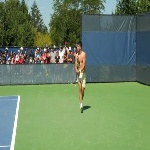
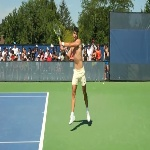
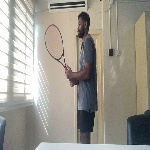
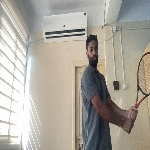
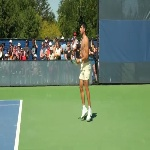

In [280]:
import os
import json
import random
import cv2
import base64
import numpy as np
import pandas as pd
from IPython.display import HTML

# 1. Setup & Load Model
EXPERT_MODEL_PATH = "models/tennis_stroke/image_expert_v1.h5"
JSON_PATH = "data/skeletons/skeletons.json"
IMAGES_DIR = "data/images_raw"
expert_model = tf.keras.models.load_model(EXPERT_MODEL_PATH)

with open(JSON_PATH, 'r') as f:
    labeled_data = [s for s in json.load(f) if s["label"] in ["backhand", "neutral"]]

# 2. Helper function to turn images into HTML
def image_to_base64_html(img_path):
    if not os.path.exists(img_path): return ""
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150)) # Thumbnail size for the table
    _, buffer = cv2.imencode('.jpg', img)
    img_str = base64.b64encode(buffer).decode()
    return f'<img src="data:image/jpeg;base64,{img_str}" width="150" height="150" />'

# 3. Pick 5 random test cases
samples = random.sample(labeled_data, 5)
results = []

for s in samples:
    path = os.path.join(IMAGES_DIR, s["image"])
    
    # Run Expert Prediction
    raw = cv2.imread(path)
    prep = cv2.resize(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB), (224, 224))
    prep = (prep.astype(np.float32) / 127.5) - 1.0
    score = expert_model.predict(np.expand_dims(prep, axis=0), verbose=0)[0][0]
    
    pred_label = "BACKHAND" if score > 0.5 else "NEUTRAL"
    
    results.append({
        "Image Preview": image_to_base64_html(path),
        "Filename": s["image"],
        "Actual": s["label"].upper(),
        "Expert Pred": pred_label,
        "Conf Score": f"{score:.2%}",
        "Match": "✅" if pred_label == s["label"].upper() else "❌"
    })

# 4. Render the Table
df_results = pd.DataFrame(results)
HTML(df_results.to_html(escape=False))

# Verified Video Extraction Pipeline
### High-Precision Backhand Detection via Skeleton Logic and CNN Validation Gate
---

In [287]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import joblib
import os
from collections import deque
from mediapipe.tasks import python

# ----------------------------
# 1. Config & Paths
# ----------------------------
VIDEO_PATH = "test_video.mp4"
OUTPUT_FOLDER = "backhand_clips"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

MODEL_ASSET_PATH = "pose_landmarker_heavy.task"
KERAS_MODEL_PATH = "models/tennis_stroke/tennis_model_keras.h5"
ENCODER_PATH = "models/tennis_stroke/label_encoder_keras.pkl"
EXPERT_MODEL_PATH = "models/tennis_stroke/image_expert_v2.keras"

CNN_THRESHOLD = 0.31   # calibrated high-precision threshold

# ----------------------------
# 2. Load Models
# ----------------------------
print("📦 Loading models...")

keras_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
expert_model = tf.keras.models.load_model(EXPERT_MODEL_PATH)
expert_model.trainable = False  # IMPORTANT: inference mode

le = joblib.load(ENCODER_PATH)

print("✅ Models loaded\n")

# ----------------------------
# 3. MediaPipe & Video Setup
# ----------------------------
base_options = python.BaseOptions(model_asset_path=MODEL_ASSET_PATH)
options = mp.tasks.vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=mp.tasks.vision.RunningMode.VIDEO
)

cap = cv2.VideoCapture(VIDEO_PATH)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

frame_buffer = deque(maxlen=fps)  # 1 second pre-buffer

# ----------------------------
# 4. Processing Loop
# ----------------------------
print("🎾 Starting backhand detection")
print("   Skeleton → candidate detection")
print("   CNN      → verification\n")

with mp.tasks.vision.PoseLandmarker.create_from_options(options) as landmarker:
    frame_count = 0
    clip_count = 0
    frames_to_record = 0
    current_writer = None
    cooldown_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        timestamp_ms = int(1000 * frame_count / fps)
        frame_count += 1

        frame_buffer.append(frame.copy())

        if cooldown_frames > 0:
            cooldown_frames -= 1

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        )

        result = landmarker.detect_for_video(mp_image, timestamp_ms)

        is_backhand = False

        if result.pose_landmarks and cooldown_frames == 0:
            landmarks = result.pose_landmarks[0]

            # ----------------------------
            # Skeleton feature extraction
            # ----------------------------
            all_coords = np.array([(lm.x * width, lm.y * height) for lm in landmarks])

            mid_hip = (all_coords[23] + all_coords[24]) / 2
            shoulder_dist = np.linalg.norm(all_coords[11] - all_coords[12])
            if shoulder_dist < 1e-3:
                shoulder_dist = 1.0

            relevant_indices = [0, 2, 5, 11, 12, 13, 14, 15, 16, 23, 24]
            input_vector = []

            for idx in relevant_indices:
                norm_x = (all_coords[idx][0] - mid_hip[0]) / shoulder_dist
                norm_y = (all_coords[idx][1] - mid_hip[1]) / shoulder_dist
                input_vector.extend([norm_x, norm_y, landmarks[idx].visibility])

            input_data = np.array([input_vector], dtype=np.float32)

            # ----------------------------
            # Skeleton prediction
            # ----------------------------
            preds = keras_model.predict_on_batch(input_data)
            class_idx = np.argmax(preds[0])
            confidence = preds[0][class_idx]
            label = le.inverse_transform([class_idx])[0]

            print(
                f"[Frame {frame_count:05d} | {frame_count/fps:6.2f}s] "
                f"Skeleton → {label} ({confidence:.2f})"
            )

            # ----------------------------
            # CNN verification
            # ----------------------------
            if label.lower() == "backhand" and confidence > 0.85:
                cnn_img = cv2.resize(
                    cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
                    (224, 224)
                )
                cnn_img = (cnn_img.astype(np.float32) / 127.5) - 1.0
                cnn_img = np.expand_dims(cnn_img, axis=0)

                cnn_score = expert_model.predict(cnn_img, verbose=0)[0][0]

                print(f"           CNN → backhand score: {cnn_score:.2f}")

                if cnn_score > CNN_THRESHOLD:
                    is_backhand = True
                    print("           ✅ VERIFIED BACKHAND")
                else:
                    print("           ❌ REJECTED by CNN")

        # ----------------------------
        # Clip saving logic (UNCHANGED)
        # ----------------------------
        if is_backhand and frames_to_record <= 0:
            clip_count += 1
            clip_path = os.path.join(
                OUTPUT_FOLDER,
                f"backhand_{clip_count}.mp4"
            )

            current_writer = cv2.VideoWriter(
                clip_path, fourcc, fps, (width, height)
            )

            for buf_frame in frame_buffer:
                current_writer.write(buf_frame)

            frames_to_record = int(fps * 1.5)
            cooldown_frames = fps * 2

            print(f"\n🎬 Recording clip #{clip_count}\n")

        elif frames_to_record > 0:
            current_writer.write(frame)
            frames_to_record -= 1

            if frames_to_record == 0:
                current_writer.release()
                current_writer = None
                print(f"🟢 Finished clip #{clip_count}\n")

cap.release()
if current_writer:
    current_writer.release()

print(f"\n✅ Done! Total verified backhands: {clip_count}")


📦 Loading models...
✅ Models loaded

🎾 Starting backhand detection
   Skeleton → candidate detection
   CNN      → verification



I0000 00:00:1769768624.836465 30520891 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1769768624.890079 30520893 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769768624.981554 30520892 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[Frame 00001 |   0.04s] Skeleton → neutral (1.00)
[Frame 00002 |   0.09s] Skeleton → neutral (1.00)
[Frame 00003 |   0.13s] Skeleton → neutral (1.00)
[Frame 00004 |   0.17s] Skeleton → neutral (0.99)
[Frame 00005 |   0.22s] Skeleton → neutral (0.98)
[Frame 00006 |   0.26s] Skeleton → neutral (0.96)
[Frame 00007 |   0.30s] Skeleton → neutral (0.95)
[Frame 00008 |   0.35s] Skeleton → neutral (0.96)
[Frame 00009 |   0.39s] Skeleton → neutral (0.93)
[Frame 00010 |   0.43s] Skeleton → neutral (0.97)
[Frame 00011 |   0.48s] Skeleton → neutral (1.00)
[Frame 00012 |   0.52s] Skeleton → neutral (1.00)
[Frame 00013 |   0.57s] Skeleton → neutral (1.00)
[Frame 00014 |   0.61s] Skeleton → neutral (1.00)
[Frame 00015 |   0.65s] Skeleton → neutral (1.00)
[Frame 00016 |   0.70s] Skeleton → neutral (1.00)
[Frame 00017 |   0.74s] Skeleton → neutral (0.94)
[Frame 00018 |   0.78s] Skeleton → backhand (0.74)
[Frame 00019 |   0.83s] Skeleton → neutral (0.86)
[Frame 00020 |   0.87s] Skeleton → neutral (0.93)

# Creating data set for rejector MLP



In [289]:
import json
import numpy as np
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split

# ----------------------------
# Paths
# ----------------------------
SKELETONS_PATH = "data/skeletons/skeletons.json"
MAIN_MODEL_PATH = "models/tennis_stroke/tennis_model_keras.h5"
ENCODER_PATH = "models/tennis_stroke/label_encoder_keras.pkl"

# ----------------------------
# Load models
# ----------------------------
main_model = tf.keras.models.load_model(MAIN_MODEL_PATH)
le = joblib.load(ENCODER_PATH)

# ----------------------------
# Build rejector dataset
# ----------------------------
X = []
y = []

with open(SKELETONS_PATH) as f:
    data = json.load(f)

for sample in data:
    if sample["label"] not in ["backhand", "neutral"]:
        continue

    joints = np.array(sample["joints_norm"]).flatten()

    # Run main model
    preds = main_model.predict(
        joints.reshape(1, -1),
        verbose=0
    )
    pred_label = le.inverse_transform([np.argmax(preds[0])])[0]

    # Keep:
    # - true backhands
    # - forehands that fool the main model
    if sample["label"] == "backhand":
        X.append(joints)
        y.append(1)
    elif sample["label"] == "neutral":
        X.append(joints)
        y.append(0)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"Rejector dataset size: {len(X)}")
print(f"Backhands: {np.sum(y)} | Forehands: {len(y) - np.sum(y)}")

# Train / val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Rejector dataset size: 353
Backhands: 109 | Forehands: 244


# Rejector MLP strict

In [291]:
def build_rejector_mlp(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [292]:
rejector = build_rejector_mlp(X_train.shape[1])

history = rejector.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    class_weight={0: 1.0, 1: 1.5},  # bias toward keeping backhands
    verbose=1
)

rejector.save("models/tennis_stroke/skeleton_rejector.keras")
print("✅ Rejector model saved")


Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5745 - loss: 0.7513 - val_accuracy: 0.8732 - val_loss: 0.5087
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.5317 - val_accuracy: 0.8873 - val_loss: 0.4702
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8333 - loss: 0.4539 - val_accuracy: 0.8873 - val_loss: 0.4587
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8972 - loss: 0.3730 - val_accuracy: 0.8873 - val_loss: 0.4487
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9184 - loss: 0.3338 - val_accuracy: 0.8873 - val_loss: 0.4319
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9433 - loss: 0.2865 - val_accuracy: 0.8873 - val_loss: 0.4127
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9326 - loss: 0.2675 - val_accuracy: 0.9155 - val_loss: 0.3881
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9504 - loss: 0.2399 - val_accuracy: 0.9014 - val_loss: 0.3734
Epoch 9

# Full script with rejector MLP

In [296]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import joblib
import os
from collections import deque
from mediapipe.tasks import python

# ----------------------------
# 1. Config & Paths
# ----------------------------
VIDEO_PATH = "r.mp4"
OUTPUT_FOLDER = "backhand_clips"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

MODEL_ASSET_PATH = "pose_landmarker_heavy.task"
KERAS_MODEL_PATH = "models/tennis_stroke/tennis_model_keras.h5"
ENCODER_PATH = "models/tennis_stroke/label_encoder_keras.pkl"
REJECTOR_PATH = "models/tennis_stroke/skeleton_rejector.keras"
rejector = tf.keras.models.load_model(REJECTOR_PATH)

CNN_THRESHOLD = 0.31   # calibrated high-precision threshold

# ----------------------------
# 2. Load Models
# ----------------------------
print("📦 Loading models...")

keras_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
expert_model = tf.keras.models.load_model(EXPERT_MODEL_PATH)
expert_model.trainable = False  # IMPORTANT: inference mode

le = joblib.load(ENCODER_PATH)

print("✅ Models loaded\n")

# ----------------------------
# 3. MediaPipe & Video Setup
# ----------------------------
base_options = python.BaseOptions(model_asset_path=MODEL_ASSET_PATH)
options = mp.tasks.vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=mp.tasks.vision.RunningMode.VIDEO
)

cap = cv2.VideoCapture(VIDEO_PATH)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

frame_buffer = deque(maxlen=fps)  # 1 second pre-buffer

# ----------------------------
# 4. Processing Loop
# ----------------------------
print("🎾 Starting backhand detection")
print("   Skeleton → candidate detection")
print("   CNN      → verification\n")

with mp.tasks.vision.PoseLandmarker.create_from_options(options) as landmarker:
    frame_count = 0
    clip_count = 0
    frames_to_record = 0
    current_writer = None
    cooldown_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        timestamp_ms = int(1000 * frame_count / fps)
        frame_count += 1

        frame_buffer.append(frame.copy())

        if cooldown_frames > 0:
            cooldown_frames -= 1

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        )

        result = landmarker.detect_for_video(mp_image, timestamp_ms)

        is_backhand = False

        if result.pose_landmarks and cooldown_frames == 0:
            landmarks = result.pose_landmarks[0]

            # ----------------------------
            # Skeleton feature extraction
            # ----------------------------
            all_coords = np.array([(lm.x * width, lm.y * height) for lm in landmarks])

            mid_hip = (all_coords[23] + all_coords[24]) / 2
            shoulder_dist = np.linalg.norm(all_coords[11] - all_coords[12])
            if shoulder_dist < 1e-3:
                shoulder_dist = 1.0

            relevant_indices = [0, 2, 5, 11, 12, 13, 14, 15, 16, 23, 24]
            input_vector = []

            for idx in relevant_indices:
                norm_x = (all_coords[idx][0] - mid_hip[0]) / shoulder_dist
                norm_y = (all_coords[idx][1] - mid_hip[1]) / shoulder_dist
                input_vector.extend([norm_x, norm_y, landmarks[idx].visibility])

            input_data = np.array([input_vector], dtype=np.float32)

            # ----------------------------
            # Skeleton prediction
            # ----------------------------
            preds = keras_model.predict_on_batch(input_data)
            class_idx = np.argmax(preds[0])
            confidence = preds[0][class_idx]
            label = le.inverse_transform([class_idx])[0]

            print(
                f"[Frame {frame_count:05d} | {frame_count/fps:6.2f}s] "
                f"Skeleton → {label} ({confidence:.2f})"
            )

            # ----------------------------
            # CNN verification
            # ----------------------------
            if label.lower() == "backhand" and confidence > 0.85 and cooldown_frames == 0:
                rejector_score = rejector.predict(
                    input_data,
                    verbose=0
                )[0][0]
            
                print(
                    f"           Rejector → backhand prob: {rejector_score:.2f}"
                )
            
                if rejector_score > 0.9:
                    is_backhand = True
                    print("           ✅ ACCEPTED by rejector")
                else:
                    print("           ❌ REJECTED as forehand")


        # ----------------------------
        # Clip saving logic (UNCHANGED)
        # ----------------------------
        if is_backhand and frames_to_record <= 0:
            clip_count += 1
            clip_path = os.path.join(
                OUTPUT_FOLDER,
                f"backhand_{clip_count}.mp4"
            )

            current_writer = cv2.VideoWriter(
                clip_path, fourcc, fps, (width, height)
            )

            for buf_frame in frame_buffer:
                current_writer.write(buf_frame)

            frames_to_record = int(fps * 1.5)
            cooldown_frames = fps * 2

            print(f"\n🎬 Recording clip #{clip_count}\n")

        elif frames_to_record > 0:
            current_writer.write(frame)
            frames_to_record -= 1

            if frames_to_record == 0:
                current_writer.release()
                current_writer = None
                print(f"🟢 Finished clip #{clip_count}\n")

cap.release()
if current_writer:
    current_writer.release()

print(f"\n✅ Done! Total verified backhands: {clip_count}")


📦 Loading models...
✅ Models loaded

🎾 Starting backhand detection
   Skeleton → candidate detection
   CNN      → verification



I0000 00:00:1770114549.122669 33395894 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1770114549.178684 33395896 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770114549.247304 33395896 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[Frame 00001 |   0.03s] Skeleton → neutral (1.00)
[Frame 00002 |   0.07s] Skeleton → neutral (1.00)
[Frame 00003 |   0.10s] Skeleton → neutral (1.00)
[Frame 00004 |   0.13s] Skeleton → neutral (1.00)
[Frame 00005 |   0.17s] Skeleton → neutral (1.00)
[Frame 00006 |   0.20s] Skeleton → neutral (1.00)
[Frame 00007 |   0.23s] Skeleton → neutral (1.00)
[Frame 00008 |   0.27s] Skeleton → neutral (1.00)
[Frame 00009 |   0.30s] Skeleton → neutral (1.00)
[Frame 00010 |   0.33s] Skeleton → neutral (1.00)
[Frame 00011 |   0.37s] Skeleton → neutral (1.00)
[Frame 00012 |   0.40s] Skeleton → neutral (1.00)
[Frame 00013 |   0.43s] Skeleton → neutral (1.00)
[Frame 00014 |   0.47s] Skeleton → neutral (1.00)
[Frame 00015 |   0.50s] Skeleton → neutral (1.00)
[Frame 00016 |   0.53s] Skeleton → neutral (1.00)
[Frame 00017 |   0.57s] Skeleton → neutral (1.00)
[Frame 00018 |   0.60s] Skeleton → neutral (1.00)
[Frame 00019 |   0.63s] Skeleton → neutral (1.00)
[Frame 00020 |   0.67s] Skeleton → neutral (1.00)
